## TabPFN

In [44]:
!pip install tabpfn
!pip install torcheval

In [45]:
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from tabpfn.scripts.decision_boundary import DecisionBoundaryDisplay

from tabpfn import TabPFNClassifier

import torch
import torcheval
import warnings
from sklearn.exceptions import UndefinedMetricWarning

import warnings
warnings.filterwarnings('ignore')


from google.colab import drive

In [46]:
if torch.cuda.is_available():
 dev = "cuda"
else:
 dev = "cpu"
device = torch.device(dev)

In [47]:
df3 = pd.read_csv('/content/combined_new.csv')

In [5]:
from sklearn.utils import shuffle
df3 = shuffle(df3)

In [6]:
df3

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,name,mutation
142,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},544a2d6b25e4372f6c4f5fe7634e6a12737ef909,3D,"(0.9375, 0.9375119805335999, 5.999996662139893)",...,6.916319,0.330220,194.831979,0.582389,0.000883,5.030642e+03,0.418059,0.915844,SHKOLDINA.nii,-1
65,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},671ceb431cb59c131a9230a30221628c099bd88d,3D,"(0.2864583432674408, 0.2864583432674408, 6.0)",...,7.480678,0.030783,144579.591151,25.722974,0.000088,3.690541e+02,0.057271,0.021957,Trekhlebova.nii,1
62,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},286c6d280cfe0dbf246a8a56d3d171ecabc036ea,3D,"(0.2864583432674408, 0.2864583432674408, 6.0)",...,6.803666,0.034548,122881.896887,17.042190,0.000193,1.754147e+02,0.063585,0.031778,Shapovalova_20.nii,1
86,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},bba899727d54ff97616c8f5652366162f735bb7b,3D,"(0.5555559992790222, 0.5555559992790222, 3.599...",...,7.226843,0.183905,2477.265353,1.907120,0.000180,3.926259e+03,0.045675,0.329985,MARGARYAN.nii,0
73,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},8a84d7859f4194dc5b973d5aa86d61f9f6f49b8d,3D,"(0.5133928656578064, 0.5133928656578064, 4.0)",...,7.138558,0.206814,1241.689264,1.479804,0.000282,2.910488e+03,0.041139,0.416442,Zolotarev_pre_23.nii,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},889f4b313a01e13be7cfb92fb04d9a2836cc51a3,3D,"(0.46875, 0.46875, 5.999997138977051)",...,7.561831,0.132289,5487.220474,9.054629,0.000051,2.712367e+03,0.029621,0.082695,Frolova_YA.nii,-1
56,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e23e4745a7bf1a487add763cbc0fb735befc5996,3D,"(0.46875, 0.46875, 5.5)",...,7.009121,0.300497,119.399470,2.413610,0.000292,2.007364e+03,0.112740,0.206080,SERENKO.nii,1
119,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},6ae745216bbb1c6fd5d9e96994570743f7ffa86e,3D,"(0.3434000015258789, 0.3434000015258789, 5.000...",...,9.080986,0.760195,0.721510,0.078881,0.000111,1.820300e+06,1.050910,7.632454,KONTIEV.nii,-1
23,v3.0.1,1.23.4,2.3.1-g42ce2,1.5.0,3.10.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e5ff0c26836837c1759059de474af6226045b095,3D,"(0.46880000829696655, 0.46880000829696655, 5.9...",...,7.335482,0.548912,3.013564,0.472109,0.000720,2.152093e+04,0.487259,1.495416,ILYIN.nii,1


In [7]:
# Предположим, что 'df' - это ваш исходный датафрейм, а 'y' - это имя столбца
X_for_test = df3[df3['mutation'] == -1]  # df1 будет содержать все строки, где значение в столбце 'y' равно -1
X_for_train = df3[df3['mutation'] != -1]  # df2 будет содержать все остальные строки

In [8]:
y_for_train = X_for_train['mutation']
X_for_train.drop(['mutation','name'], axis=1, inplace=True)

X_for_train=X_for_train.iloc[:, 22:]
X_for_train=X_for_train.iloc[:, :107]


y_for_test = X_for_test['mutation']
X_for_test.drop(['mutation','name'], axis=1, inplace=True)

X_for_test=X_for_test.iloc[:, 22:]
X_for_test=X_for_test.iloc[:, :107]

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X, y = smote.fit_resample(X_for_train, y_for_train)

In [15]:
# N_ensemble_configurations defines how many estimators are averaged, it is bounded by #features * #classes
# more ensemble members are slower, but more accurate
classifier_TabPFNC = TabPFNClassifier(device=dev, N_ensemble_configurations=30)

In [19]:
ind = []
col = []
columns=X.columns

# classifiers = []
num_features=[100, 80, 60, 40, 20]
for num in num_features:
    while True:
        indices_row = np.arange(len(X))
        indices_col = np.arange(len(X.columns))
        np.random.shuffle(indices_row)
        np.random.shuffle(indices_col)

        #shuffle columns
        X_shuffled = X[columns[indices_col]]
        # y_shuffled = y.loc[indices_row]

        # Используйте перемешанные индексы для получения перемешанных данных
        X_shuffled = X_shuffled.loc[indices_row]
        y_shuffled = y.loc[indices_row]

        X_shuffled=X_shuffled.iloc[:, :num]


        X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.33, random_state=42, shuffle=False)

        start = time.time()

        classifier_TabPFNC.fit(X_train, y_train)
        y_eval, p_eval = classifier_TabPFNC.predict(X_test, return_winning_probability=True)
        if (precision_score(y_test, y_eval)>=0.85 and recall_score(y_test, y_eval)>=0.85):
          col.append(X_shuffled.columns)
          ind.append(X_shuffled.index)
          print( 'Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval), 'Precision', precision_score(y_test, y_eval), 'Recall', recall_score(y_test, y_eval))
          break


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Prediction time:  8.432725667953491 Accuracy 0.8775510204081632 Precision 0.88 Recall 0.88


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

Prediction time:  5.023537635803223 Accuracy 0.8979591836734694 Precision 0.85 Recall 0.8947368421052632


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

Prediction time:  4.807775259017944 Accuracy 0.8775510204081632 Precision 0.8695652173913043 Recall 0.8695652173913043


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

Prediction time:  5.8007073402404785 Accuracy 0.8571428571428571 Precision 0.8518518518518519 Recall 0.8846153846153846


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.

Prediction time:  4.749155759811401 Accuracy 0.8367346938775511 Precision 0.8518518518518519 Recall 0.8518518518518519


In [20]:
#shuffle columns
X_shuffled=X[col[2]]
y_shuffled=y


X_shuffled = X_shuffled.loc[ind[2]]
y_shuffled = y.loc[ind[2]]

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=42, shuffle=False)

start = time.time()
classifier_TabPFNC.fit(X_train, y_train)
y_eval, p_eval = classifier_TabPFNC.predict(X_test, return_winning_probability=True)
print( 'Prediction time: ', time.time() - start, 'Accuracy', accuracy_score(y_test, y_eval), 'Precision', precision_score(y_test, y_eval), 'Recall', recall_score(y_test, y_eval))


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Prediction time:  6.615358114242554 Accuracy 0.8666666666666667 Precision 0.8823529411764706 Recall 0.8823529411764706


In [202]:
torch.save(classifier_TabPFNC, '/content/model_TabPFN.pth')

## NN

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import torch
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

if torch.cuda.is_available():
 dev = "cuda"
else:
 dev = "cpu"
device = torch.device(dev)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
from torchvision import datasets, transforms
from torch. utils.data import DataLoader

##Train test split

сплитим X и y, для того, чтобы сделать train и test loaders

In [50]:
train = X.loc[X_train.index]
train['mutation']=y_train

In [51]:
test = X.loc[X_test.index]
test['mutation']=y_test

In [65]:
# convert into PyTorch tensors

batchSize = 32

y_train_torch = torch.tensor(train['mutation'].values, dtype=torch.float32).to(device)
X_train_torch = torch.tensor(train.drop(['mutation'], axis = 1).values, dtype=torch.float32).to(device)

y_test_torch = torch.tensor(test['mutation'].values, dtype=torch.float32).to(device)
X_test_torch = torch.tensor(test.drop(['mutation'], axis = 1).values, dtype=torch.float32).to(device)


# create DataLoader, then take one batch
loader_train = DataLoader(list(zip(X_train_torch,y_train_torch)), shuffle=True, batch_size=batchSize)
loader_test = DataLoader(list(zip(X_test_torch,y_test_torch)), shuffle=True, batch_size=batchSize)

##CNN

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNetBinaryClassification(nn.Module):
    def __init__(self, input_shape, num_classes):

          super(ConvNetBinaryClassification, self).__init__()
          self.conv1 = nn.Conv1d(in_channels=107, out_channels=32, kernel_size=1)
          self.batch_norm = nn.BatchNorm1d(32)
          self.fc1 = nn.Linear(32, 1)  # Вычисляем размер после сверточного слоя


    def forward(self, x):
          x = x.unsqueeze(2)
          x = torch.relu(self.conv1(x))#batch_size / filters/ size [32,3,32*]
          x = self.batch_norm(x)
          x = torch.flatten(x, 1)
          x = self.fc1(x)
          return torch.sigmoid(x)


# Пример использования
input_dim = train.shape[1]-1
sequence_length = train.shape[0]
input_shape = (batchSize, input_dim, sequence_length)  # Где input_dim - количество признаков в таблице, sequence_length - длина последовательности
num_classes = 1  # Для бинарной классификации
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ConvNetBinaryClassification(input_shape, num_classes).to(device)

In [67]:
# Получаем количество параметров в модели
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

3553


In [55]:
# Define training params
epochs = 50
lr = 0.01
momentum = 0.5
log_interval = 10
loss_fn = nn.BCELoss()

In [56]:
import torch.optim as optim
# Обучение модели
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):

            inputs=inputs.to(device)
            labels=labels.to(device)

            optimizer.zero_grad()
            # print(inputs.shape)

            outputs = model(inputs)

            loss = loss_fn(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Оценка модели
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs).squeeze()  # Применяем round, чтобы получить бинарные предсказания
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if torch.numel(predicted) > 1:  # If `predicted` has more than one element
                predictions.extend(predicted.tolist())
            else:  # If `predicted` has only one element
                predictions.append(predicted.item())
            true_labels.extend(labels.tolist())
            print('pred ', predictions, '\n', 'tru_lab ', true_labels, '\n')
    accuracy = correct / total
    print("accuracy score:", accuracy_score(predictions, true_labels),'Precision:', precision_score(predictions, true_labels), 'Recall:', recall_score(predictions, true_labels))


# Инициализация модели, оптимизатора и функции потерь
input_shape = train.shape[1:]  # Размерность входных данных, кроме размерности батча
num_classes = 1  # Для бинарной классификации

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
train_model(model, loader_train, optimizer, loss_fn, num_epochs=30)

# Оценка модели на тестовом наборе данных
evaluate_model(model, loader_test)

Epoch 1/30, Loss: 0.7103
Epoch 2/30, Loss: 0.6878
Epoch 3/30, Loss: 0.6847
Epoch 4/30, Loss: 0.6636
Epoch 5/30, Loss: 0.6828
Epoch 6/30, Loss: 0.6572
Epoch 7/30, Loss: 0.6632
Epoch 8/30, Loss: 0.6745
Epoch 9/30, Loss: 0.6614
Epoch 10/30, Loss: 0.6805
Epoch 11/30, Loss: 0.6679
Epoch 12/30, Loss: 0.6755
Epoch 13/30, Loss: 0.6738
Epoch 14/30, Loss: 0.6640
Epoch 15/30, Loss: 0.6735
Epoch 16/30, Loss: 0.6710
Epoch 17/30, Loss: 0.6548
Epoch 18/30, Loss: 0.6711
Epoch 19/30, Loss: 0.6633
Epoch 20/30, Loss: 0.6592
Epoch 21/30, Loss: 0.6517
Epoch 22/30, Loss: 0.6663
Epoch 23/30, Loss: 0.6599
Epoch 24/30, Loss: 0.6507
Epoch 25/30, Loss: 0.6480
Epoch 26/30, Loss: 0.6562
Epoch 27/30, Loss: 0.6966
Epoch 28/30, Loss: 0.6735
Epoch 29/30, Loss: 0.6791
Epoch 30/30, Loss: 0.6773
pred  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] 
 tru_lab  [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 

## FN

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(107, 32)  # Входной слой: 107 входных признаков, 64 нейрона
        self.fc3 = nn.Linear(32, 1)    # Выходной слой: 32 нейрона, 1 выход (бинарная классификация)

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # Применяем ReLU к выходу первого слоя
        x = torch.sigmoid(self.fc3(x))  # Применяем сигмоиду к выходу третьего слоя
        return x

# Создаем экземпляр модели
net = SimpleNet()

In [62]:
def train_(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()  # Переводим модель в режим обучения

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Обнуляем градиенты

            # Прямой проход (forward pass)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            # Обратное распространение (backward pass) и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Выводим средний loss на каждой эпохе
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(train_loader)}")

    print("Обучение завершено!")

def evaluate(model, test_loader, criterion):
    model.eval()  # Переводим модель в режим оценки (не обучения)

    predictions = []
    true_labels = []
    correct = 0
    total = 0
    with torch.no_grad():

        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs).squeeze()  # Преобразуем вероятности в бинарные предсказания
            print('predicted ', predicted.tolist(), '\n')

            correct += (predicted.squeeze() == labels).sum().item()

            if torch.numel(predicted) > 1:  # If `predicted` has more than one element
                predictions.extend(predicted.tolist())
            else:  # If `predicted` has only one element
                predictions.append(predicted.item())
            true_labels.extend(labels.tolist())
            print('pred ', predictions, '\n', 'tru_lab ', true_labels, '\n')

            total += labels.size(0)
    accuracy = correct / total
    print(f"Accuracy on test data: {accuracy:.2f}", "accuracy score:", accuracy_score(predictions, true_labels),'Precision:', precision_score(predictions, true_labels), 'Recall:', recall_score(predictions, true_labels))

    return accuracy

# Инициализация модели, оптимизатора и функции потерь
input_shape = 107  # Размерность входных данных, кроме размерности батча
num_classes = 1  # Для бинарной классификации

optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_fn=nn.BCELoss()

# Обучение модели
train_(net, loader_train, optimizer, loss_fn, num_epochs=30)

# Оценка модели на тестовом наборе данных
evaluate(net, loader_test, loss_fn)

Epoch [1/30] Loss: 47.72727298736572
Epoch [2/30] Loss: 48.7926139831543
Epoch [3/30] Loss: 48.4375
Epoch [4/30] Loss: 48.0823860168457
Epoch [5/30] Loss: 49.857954025268555
Epoch [6/30] Loss: 47.372159004211426
Epoch [7/30] Loss: 49.14772701263428
Epoch [8/30] Loss: 47.72727298736572
Epoch [9/30] Loss: 48.4375
Epoch [10/30] Loss: 48.0823860168457
Epoch [11/30] Loss: 47.372159004211426
Epoch [12/30] Loss: 47.72727298736572
Epoch [13/30] Loss: 48.0823860168457
Epoch [14/30] Loss: 48.4375
Epoch [15/30] Loss: 47.372159004211426
Epoch [16/30] Loss: 47.01704549789429
Epoch [17/30] Loss: 48.0823860168457
Epoch [18/30] Loss: 47.72727298736572
Epoch [19/30] Loss: 48.7926139831543
Epoch [20/30] Loss: 47.72727298736572
Epoch [21/30] Loss: 49.14772701263428
Epoch [22/30] Loss: 47.72727298736572
Epoch [23/30] Loss: 48.7926139831543
Epoch [24/30] Loss: 48.7926139831543
Epoch [25/30] Loss: 47.372159004211426
Epoch [26/30] Loss: 49.14772701263428
Epoch [27/30] Loss: 47.372159004211426
Epoch [28/30] L

0.43333333333333335

In [215]:
torch.save(net, '/content/model_net.pth')

## Adaboost

In [27]:
import zipfile
import requests
import matplotlib.pyplot as plt
import glob
import random
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
X_train_for_adaboost=train
y_train_for_adaboost = y_train
X_train_for_adaboost.drop(['mutation'], axis=1, inplace=True)

X_test_for_adaboost=test
y_test_for_adaboost = y_test
X_test_for_adaboost.drop(['mutation'], axis=1, inplace=True)


In [30]:
import time
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score


from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import Pipeline

In [31]:
base_models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Adaptive Boosting", AdaBoostClassifier(random_state=42)),
    ("SVM", SVC(random_state=42)),
    ("k-Nearest Neighbors", KNeighborsClassifier()),
    ("LightGBM", LGBMClassifier(random_state=42)),
    ("Ridge Logistic Regression", RidgeClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(random_state=42))
]

In [32]:
#initialize lists to store model evaluation metrics
model_names = []
min_accuracies = []
max_accuracies = []
mean_accuracies = []
std_accuracies = []
min_recalls = []
max_recalls = []
mean_recalls = []
std_recalls = []
model_times = []

#Cross-validation settings
n_splits = 4
split = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

n = 0
for name, model in base_models:
    start_time = time.time()
    model_steps = Pipeline(steps=[('scaler', RobustScaler()),('model', model)])
    n += 1
    print(f'{n}/{len(base_models)} ************************** {name} ************* \n')

    # Define scoring metrics (accuracy and recall)
    scoring = {'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(recall_score)}

    # Perform cross-validation
    cv_results = cross_validate(model_steps,
                                X_train_for_adaboost, y_train_for_adaboost,
                                cv=split,
                                scoring=scoring,
                                n_jobs=-1,
                                verbose=1)
    print()
    # Record evaluation metrics
    model_names.append(name)
    min_accuracies.append(round(min(cv_results['test_accuracy']), 3))
    max_accuracies.append(round(max(cv_results['test_accuracy']), 3))
    mean_accuracies.append(round(np.mean(cv_results['test_accuracy']), 3))
    std_accuracies.append(round(np.std(cv_results['test_accuracy']), 3))

    min_recalls.append(round(min(cv_results['test_recall']), 3))
    max_recalls.append(round(max(cv_results['test_recall']), 3))
    mean_recalls.append(round(np.mean(cv_results['test_recall']), 3))
    std_recalls.append(round(np.std(cv_results['test_recall']), 3))

    end_time = time.time()
    model_times.append(round(end_time - start_time, 3))


1/8 ************************** Decision Tree ************* 



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



2/8 ************************** Random Forest ************* 



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



3/8 ************************** Adaptive Boosting ************* 



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



4/8 ************************** SVM ************* 


5/8 ************************** k-Nearest Neighbors ************* 



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



6/8 ************************** LightGBM ************* 



[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



7/8 ************************** Ridge Logistic Regression ************* 


8/8 ************************** Logistic Regression ************* 




[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


In [33]:
model_names = [name for name, _ in base_models]

datas = {
    'Model': model_names,
    'Min Accuracy': min_accuracies,
    'Max Accuracy': max_accuracies,
    'Mean Accuracy': mean_accuracies,
    'Std Accuracy': std_accuracies,
    'Min Recall': min_recalls,
    'Max Recall': max_recalls,
    'Mean Recall': mean_recalls,
    'Std Recall': std_recalls,
    'Time (s)': model_times
}
df = pd.DataFrame(datas)
df


,Model,Min Accuracy,Max Accuracy,Mean Accuracy,Std Accuracy,Min Recall,Max Recall,Mean Recall,Std Recall,Time (s)
0,Decision Tree,0.600,0.828,0.747,0.088,0.400,0.929,0.671,0.189,2.196
1,Random Forest,0.600,0.828,0.738,0.084,0.267,0.857,0.638,0.228,0.750
2,Adaptive Boosting,0.690,0.828,0.763,0.049,0.643,1.000,0.774,0.141,0.578
3,SVM,0.467,0.552,0.509,0.031,0.000,0.929,0.679,0.393,0.162
4,k-Nearest Neighbors,0.517,0.633,0.568,0.046,0.286,0.571,0.439,0.108,0.207
5,LightGBM,0.667,0.931,0.789,0.102,0.400,0.857,0.707,0.187,2.125
6,Ridge Logistic Regression,0.586,0.724,0.653,0.050,0.267,0.643,0.460,0.135,0.165
7,Logistic Regression,0.552,0.759,0.644,0.088,0.200,0.714,0.496,0.188,0.233


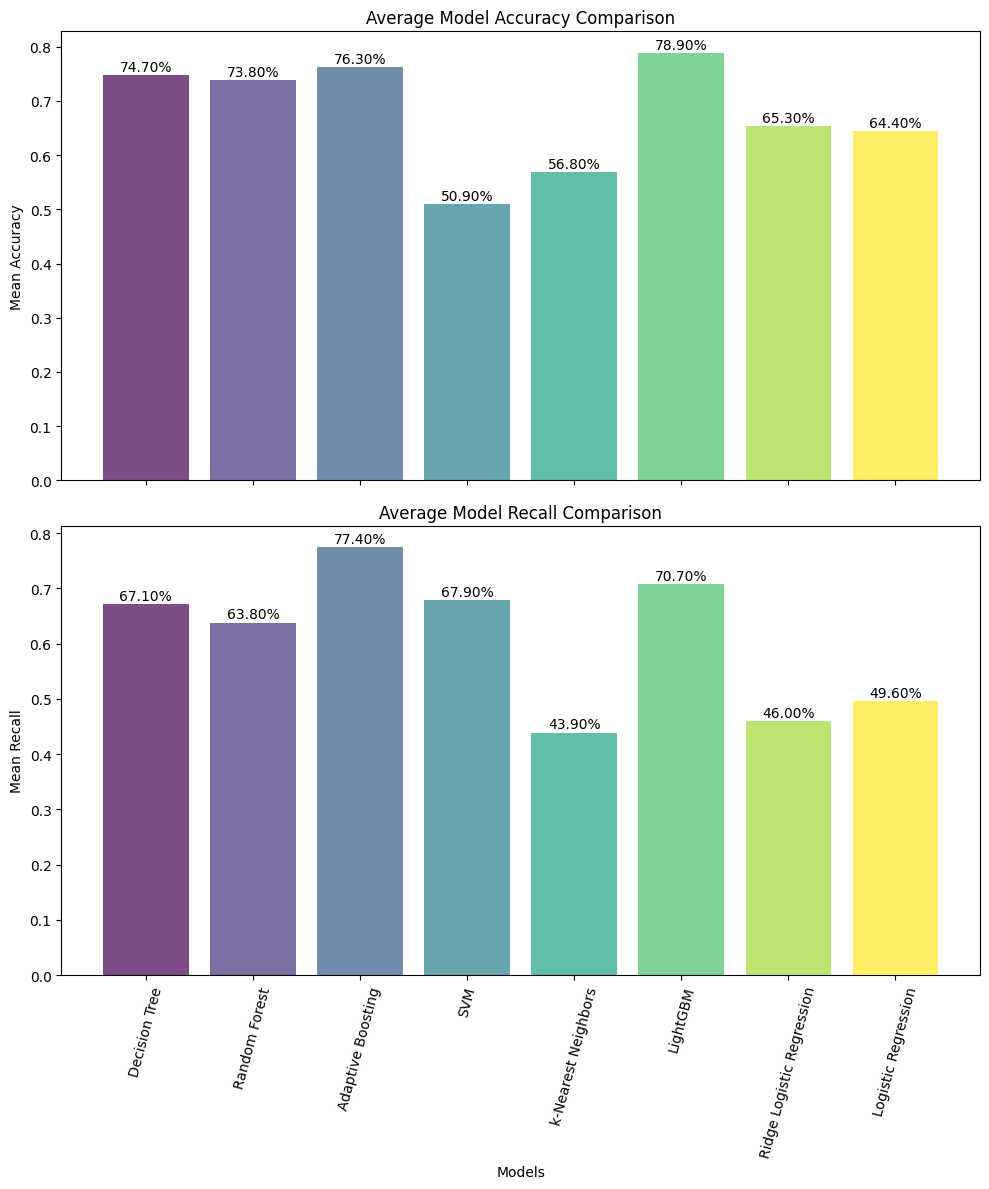

In [34]:
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot Average Accuracy
bars_acc = axs[0].bar(df['Model'], df['Mean Accuracy'], color=colors, alpha=0.7)
axs[0].set_ylabel('Mean Accuracy')
axs[0].set_title('Average Model Accuracy Comparison')

# Display the accuracy scores on top of each bar
for bar in bars_acc:
    height = bar.get_height()
    axs[0].annotate(f'{100*height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# Plot Average Recall
bars_recall = axs[1].bar(df['Model'], df['Mean Recall'], color=colors, alpha=0.7)
axs[1].set_xlabel('Models')
axs[1].set_ylabel('Mean Recall')
axs[1].set_title('Average Model Recall Comparison')
axs[1].tick_params(axis='x', rotation=75)

# Display the recall scores on top of each bar
for bar in bars_recall:
    height = bar.get_height()
    axs[1].annotate(f'{100*height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [35]:
# Initialize RobustScaler
scaler = RobustScaler()

# Transform X_res with RobustScaler
X_train_scaled = scaler.fit_transform(X_train_for_adaboost)
X_test_scaled = scaler.transform(X_test_for_adaboost)

#create instance for the classifier
# classifier = LGBMClassifier(random_state=42)
# classifier = DecisionTreeClassifier(random_state=42)
# classifier = SVC(random_state=42)
classifier_Adaboost = AdaBoostClassifier(random_state=42)
# classifier = RandomForestClassifier(random_state=42)
# classifier = KNeighborsClassifier()
# classifier = RidgeClassifier(random_state=42)
# classifier = LogisticRegression(random_state=42)

classifier_Adaboost.fit(X_train_scaled,y_train_for_adaboost) # fit
y_pred = classifier_Adaboost.predict(X_test_scaled) #predict
accuracy = accuracy_score(y_test_for_adaboost, y_pred)
recall = recall_score(y_test_for_adaboost, y_pred)


In [36]:
print(f'Accuracy: {accuracy:.3f}')
print(f'Recall: {recall:.3f}\n')

Accuracy: 0.700
Recall: 0.765



In [37]:
torch.save(classifier_Adaboost, '/content/model_Adaboost.pth')

In [226]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[16,  0],
       [ 0, 14]])

## Voting

In [228]:
import numpy as np
from scipy.stats import mode

testing_X=[]
n_trees = 3
classifiers = [classifier_TabPFNC,classifier_Adaboost, net]

# here we will store predictions for all samples and all base classifiers
base_pred = np.zeros((X_test.shape[0], n_trees), dtype="int")
for i in range(n_trees):
    # obtain the predictions from each tree
    if classifiers[i]==classifier_TabPFNC:
      base_pred[:,i], p_eval = classifiers[i].predict(X_test, return_winning_probability=True)

    if classifiers[i]==classifier_Adaboost:
      base_pred[:,i]= classifiers[i].predict(X_test_for_adaboost)

    if classifiers[i]==net:
      outputs = classifiers[i](next(iter(loader_test))[0])
      base_pred[:,i]= torch.round(outputs).squeeze().tolist()
print(base_pred)

# aggregate predictions by majority voting
pred = mode(base_pred, axis=1)[0].ravel()

print('предсказания - ', pred, '\n')

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


[[0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [0 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [0 1 1]]
предсказания -  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
